# Recursive Green Function code - basic usage

In [1]:
from multiprocessing import Pool
import RGF_src as rgf
import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.insert(1, '/home/simao/projects_sync/codes/tight-binding-test/src/')
import band_structure as bs

# Example 1: 1D TB
The 1D tight-binding lattice can be obtained by using the 2D lattice of width 1 without periodic boundary conditions

In [2]:
# sample geometry
width=1
length=6

# Boundary conditions. Twist false means open boundary conditions. 
# k is only used when twist=True but it needs to exist
twist = False
k = 0

# set the Hamiltonian. ander is the strength of Anderson disorder
sys = rgf.rgf()
sys.set_2dtb_nanoribbon(width, length, twist, k, ander=0.0)



## Landauer

In [3]:
# list of complex energies
eta = 1e-5
NE = 200
energies = np.linspace(-4,4, NE)
zs = energies + eta*1j

land = sys.get_landauer(zs)

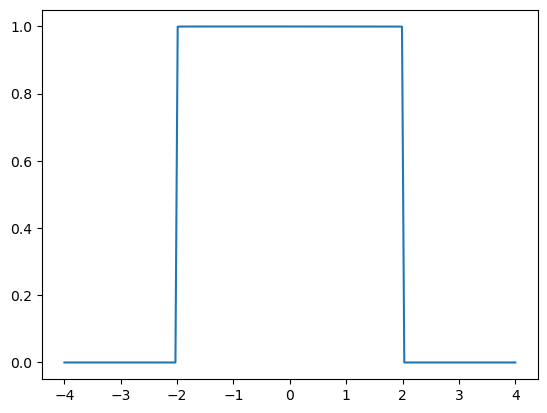

In [4]:
plt.plot(energies, np.real(land))
plt.show()

# Example 2: Graphene Hamiltonian with Rashba

In [9]:
t  = -1
λR = 0.3*0
Δx = 0.4*0

# sample geometry
width=3
length=5
twist = False
k = 0.0
n = 2 # slice

NE = 200
energies = np.linspace(-3.5,3.5, NE)
eta = 1e-5
zs = energies + 1j*eta
    
# Initialize the graphene + Rashba system implemented with the general TB functionality
jaro = rgf.rgf()
jaro.set_branislav(width, length, twist, k, t=t, λR=λR, λex=Δx)
land = jaro.get_landauer(zs)


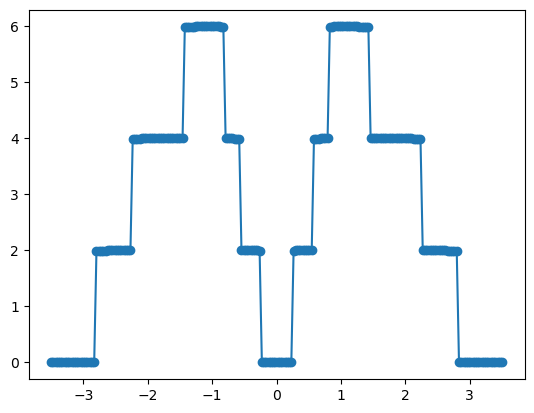

In [11]:
plt.plot(energies, land, '-o')
plt.show()

In [17]:
# data = np.zeros([NE,2])
# data[:,0] = energies
# data[:,1] = np.real(land)

# np.savetxt(f"landauer_W{width}L{length}_R{λR}E{Δx}.dat", np.real(data))